![Airbnb logo](https://japanesquest.com/wp-content/uploads/2017/10/airbnb-logo.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

import statsmodels
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
clean_sum_listings = pd.read_csv('clean_sum_listings.csv')

In [3]:
def heatmap_ml (df):
    corr = df.corr().round(2)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(16, 8))

        ax = sns.heatmap(corr, cmap = 'RdBu_r', annot=True,  mask=mask, vmax=1, vmin= -1, square=True)

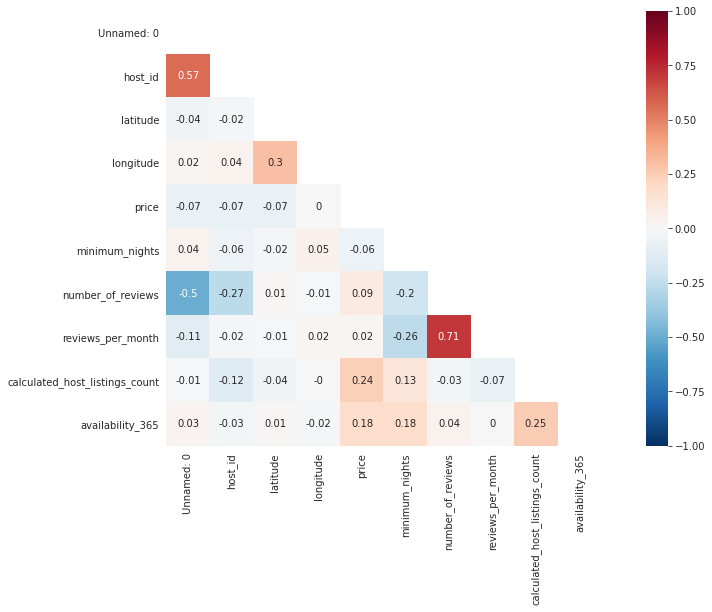

In [4]:
heatmap_ml(clean_sum_listings)

- Strongest correlation is between **reviews_per_month and number_of_reviews** (0.7)
- **host_id and Unamed: 0** seem somewhat correlated (0.57) but give out very little info
- **Longitude and latitude** are showing a slight correlation given that they both relate to location coordinates (0.3)
- Finally, **calculated_host_listings_count** seems to have a slight correlation with **availability_365** (0.25) and **price** (0.18) 

### 1. Preprocessing variables

Text(0.5, 0, 'log(1+price)')

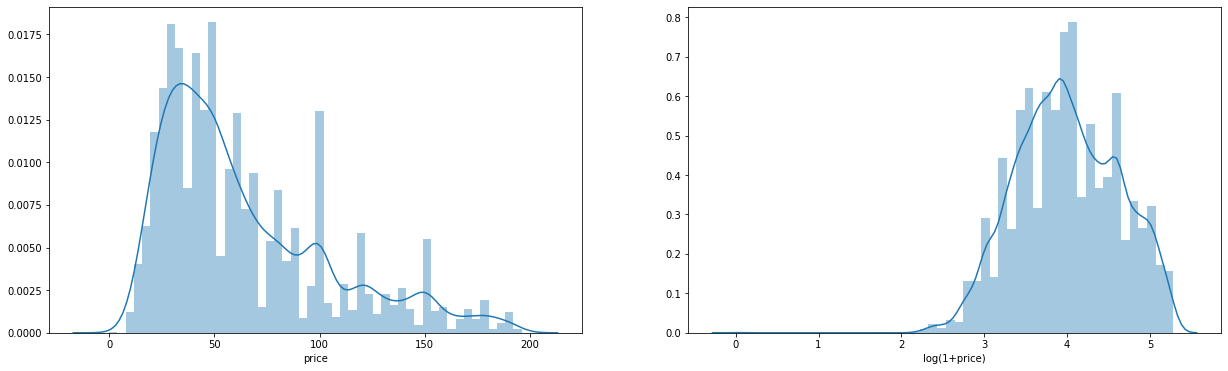

In [5]:
# Given that the original price distribution seems to be positively skewed, a log transformation and removal 
# of outliers makes the distribution look much closer to normal

# Plotting original and logaritmic PRICE  
fig, axes = plt.subplots(1,2, figsize=(21,6))

# original column
sns.distplot(clean_sum_listings['price'], ax=axes[0])

# applying logaritmic scale to PRICE column
sns.distplot(np.log1p(clean_sum_listings['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')

In [6]:
# Return the natural logarithm of one plus the input array, element-wise
# Calculates log(1 + x).

clean_sum_listings['price'] = np.log1p(clean_sum_listings['price'])

In [7]:
clean_sum_listings.columns

Index(['Unnamed: 0', 'name', 'host_id', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

### 1.1 Host_id

In [8]:
# Since there's a rather reduced number of unique hosts compared to the total number of properties in Barcelona
# we will keep the column as one of the variables to use in our models

print('There are {} unique hosts renting out  a total number of {} properties'.format(len(clean_sum_listings['host_id'].unique()), 
                                                                                       clean_sum_listings.shape[0]))

There are 8097 unique hosts renting out  a total number of 15753 properties


### 1.2 Unamed: 0

In [9]:
# This column has very little information and doesn't have any correlation besides with host_id so we're
# removing it from our dataset

clean_sum_listings = clean_sum_listings.drop(['Unnamed: 0'], axis=1)

### 1.3 Minimum_nights 

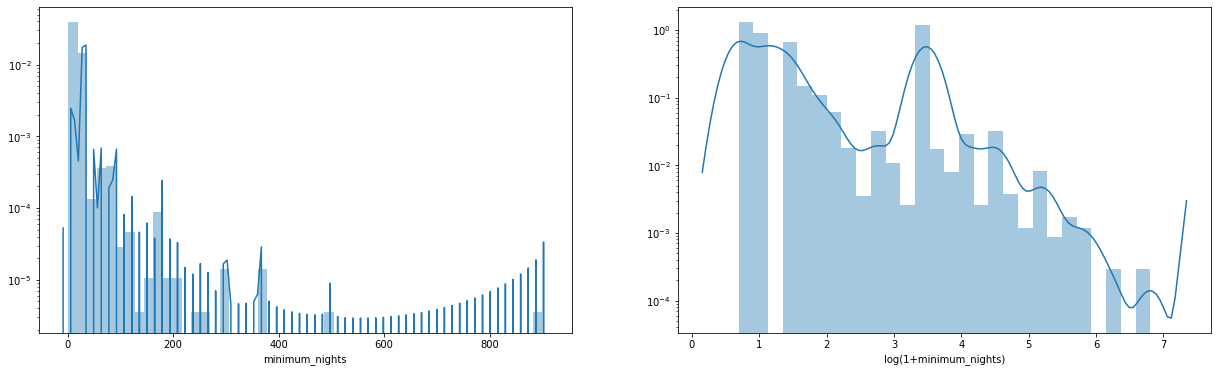

In [10]:
# Given that the original minimum_nights distribution also reveals a large number of outliers, 
# a log transformation makes the distribution look much closer to normal

# Plotting original and logaritmic PRICE  
fig, axes = plt.subplots(1,2, figsize=(21,6))

# original column
sns.distplot(clean_sum_listings['minimum_nights'], ax=axes[0])
axes[0].set_yscale('log')


# applying logaritmic scale to MIN_NIGHTS column
sns.distplot(np.log1p(clean_sum_listings['minimum_nights']), ax=axes[1])
axes[1].set_xlabel('log(1+minimum_nights)')
axes[1].set_yscale('log')

### 1.4 Reviews per month

In [11]:
# Reviews_per_month is so very positely skewed due to the high number of listings with a reduced number of reviews
# per month and the logaritmic scale doesn't seem to significantly fix it 

# original column
sns.distplot(clean_sum_listings['reviews_per_month'], ax=axes[0])

# applying logaritmic scale to REVIEWS_PER_MONTH column
sns.distplot(np.log1p(clean_sum_listings['reviews_per_month']), ax=axes[1])
axes[1].set_xlabel('log(1+reviews_per_month)')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:347: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:347: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


Text(0.5, 18.106250000000003, 'log(1+reviews_per_month)')

### 2. Pairplot 

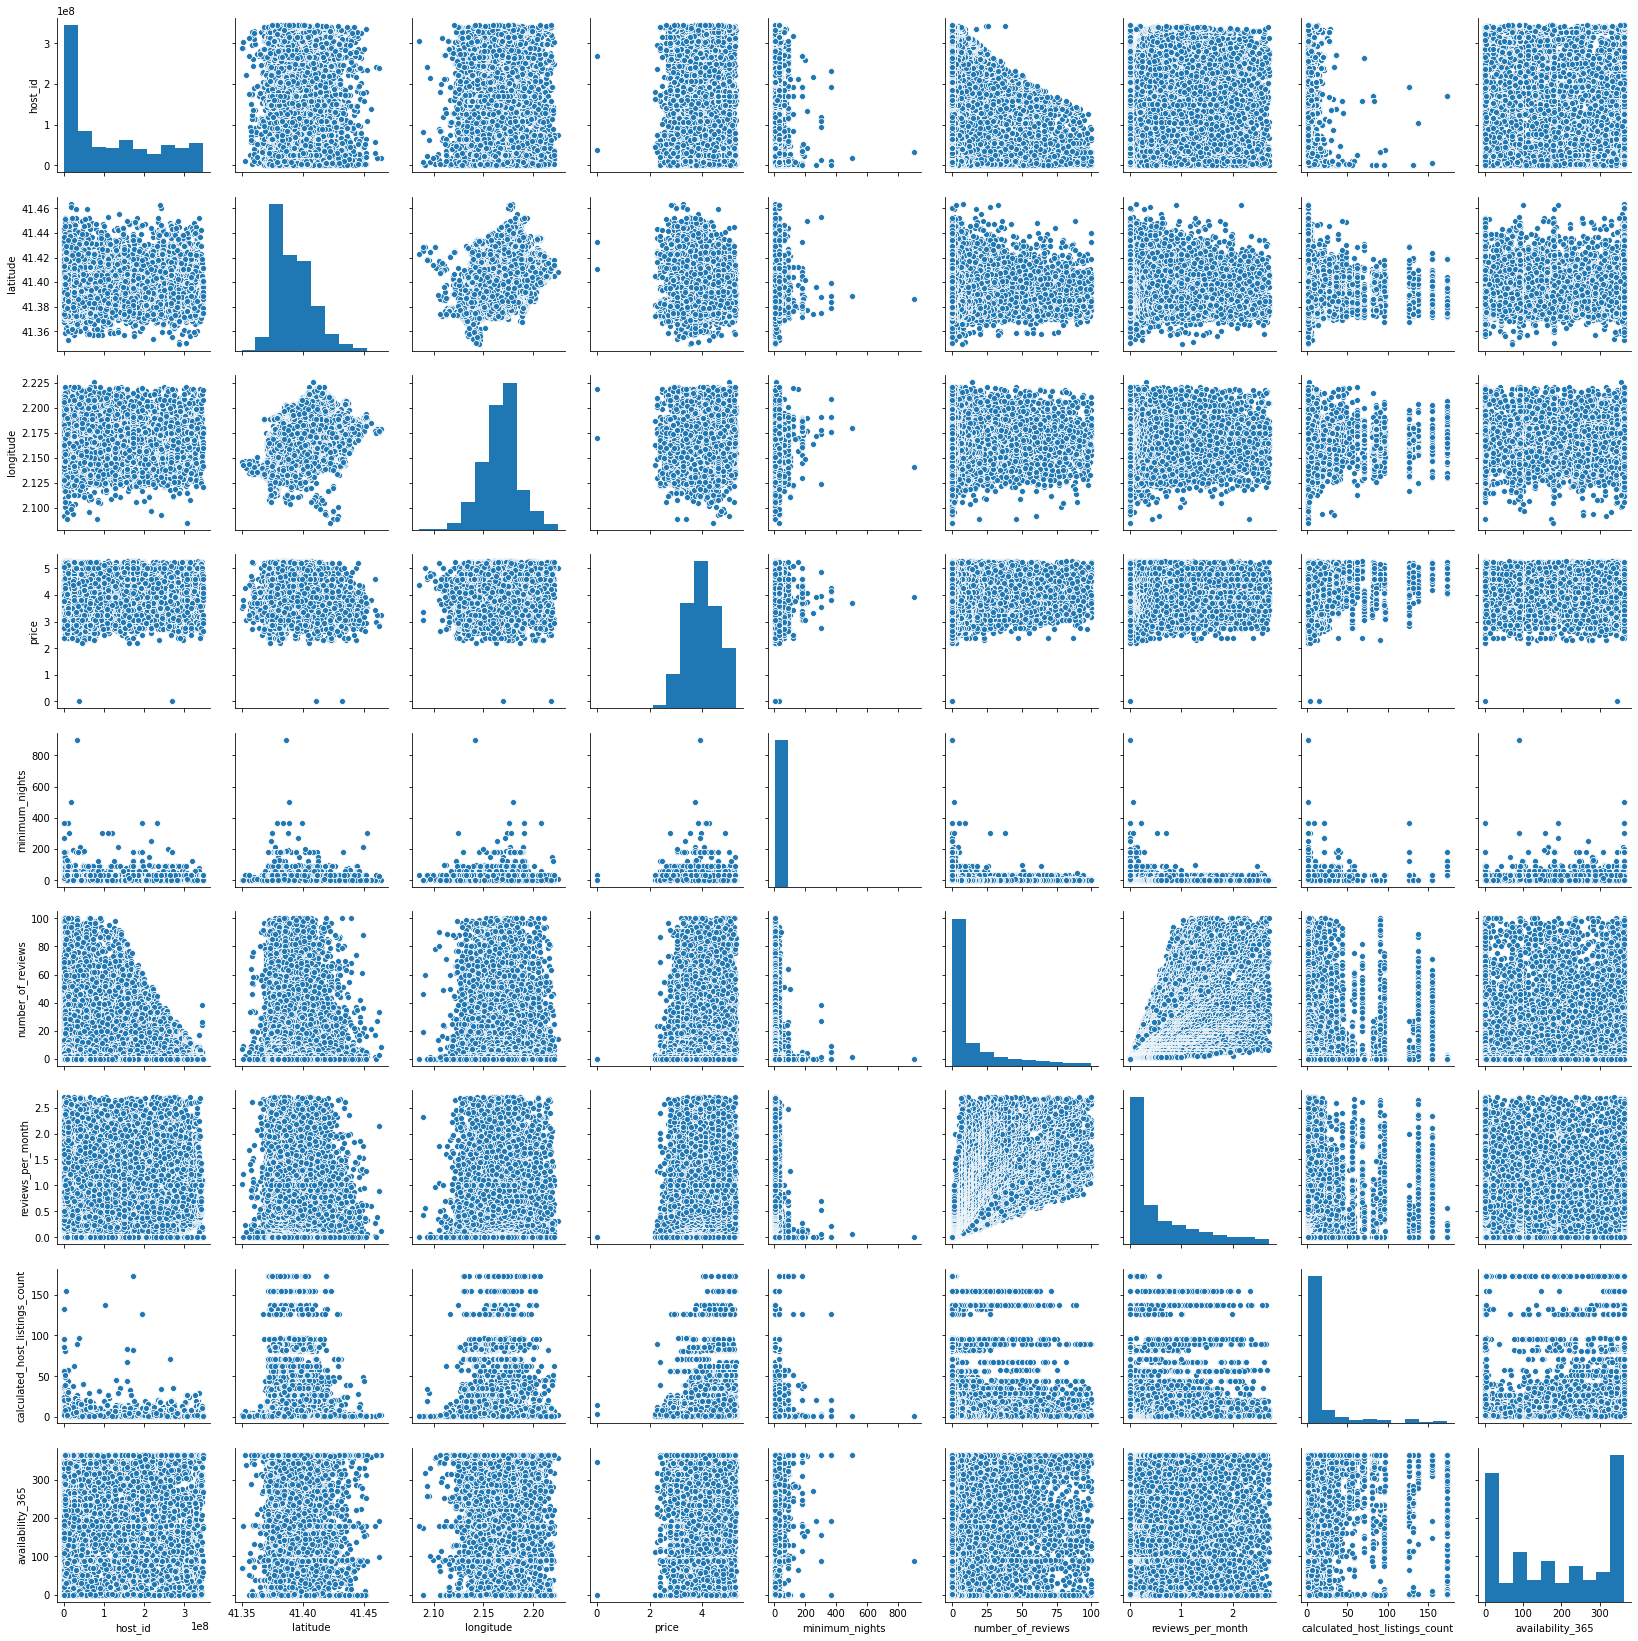

In [12]:
sns.pairplot(clean_sum_listings)

### 3. Enconding Features

In [13]:
clean_sum_listings.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Comf. double room/private bathroom,73163,Ciutat Vella,el Barri Gòtic,41.38077,2.17551,Private room,4.110874,3,2,0.05,3,90
1,"Gaudi Attic 2, Friendly Rentals",136853,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40928,2.16112,Entire home/apt,4.204693,1,94,0.83,29,331
2,Sagrada Familia area - Còrsega 1,135703,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40566,2.17015,Entire home/apt,4.948760,2,63,0.59,6,329
3,Private Double room - Plaza Real,73163,Ciutat Vella,el Barri Gòtic,41.37916,2.17535,Private room,4.615121,5,8,0.07,3,180
4,In front of the beach,158596,Ciutat Vella,la Barceloneta,41.37906,2.19141,Private room,3.526361,2,73,0.70,1,352


In [14]:
categorical_features = clean_sum_listings.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))

Categorical features: (15753, 4)


In [15]:
# One-Hot Enconding neighbourhood
dummy_neighbourhood = pd.get_dummies(clean_sum_listings['neighbourhood'])

# One-Hot Enconding neighbourhood_group
dummy_neighbourhood_group = pd.get_dummies(clean_sum_listings['neighbourhood_group'])

# One-Hot Enconding room_type
dummy_roomtype =pd.get_dummies(clean_sum_listings['room_type'])

In [16]:
# Concatenating all dummies and putting them together in the original dataset

clean_sum_listings = pd.concat([clean_sum_listings,dummy_neighbourhood, dummy_neighbourhood_group,dummy_roomtype ],axis=1)

# Dropping all the originally categorical columns including NAME
clean_sum_listings.drop(['name','neighbourhood', 'neighbourhood_group','room_type'],axis=1, inplace=True)

In [17]:
clean_sum_listings.shape

(15753, 93)

In [18]:
clean_sum_listings.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Can Baró,...,Les Corts,Nou Barris,Sant Andreu,Sant Martí,Sants-Montjuïc,Sarrià-Sant Gervasi,Entire home/apt,Hotel room,Private room,Shared room
0,73163,41.38077,2.17551,4.110874,3,2,0.05,3,90,0,...,0,0,0,0,0,0,0,0,1,0
1,136853,41.40928,2.16112,4.204693,1,94,0.83,29,331,0,...,0,0,0,0,0,0,1,0,0,0
2,135703,41.40566,2.17015,4.948760,2,63,0.59,6,329,0,...,0,0,0,0,0,0,1,0,0,0
3,73163,41.37916,2.17535,4.615121,5,8,0.07,3,180,0,...,0,0,0,0,0,0,0,0,1,0
4,158596,41.37906,2.19141,3.526361,2,73,0.70,1,352,0,...,0,0,0,0,0,0,0,0,1,0


### 4. Train/Test Split

In [19]:
# let's separate the data into training and testing set

from sklearn.model_selection import train_test_split

# let's separate the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(clean_sum_listings.drop('price', axis=1),
                                                    clean_sum_listings['price'],
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape

((12602, 92), (3151, 92))

In [21]:
# Robust Scaler - the centering and scaling statistics of this scaler are based on percentiles and are 
# therefore not influenced by a few number of very large marginal outliers.

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# transform train and test sets
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### 5. Machine Learning Models

### 5.1 K-fold cross-validation 

In [43]:
#  K-fold cross-validation with 5 folds
#  k that refers to the number of groups that a given data sample is to be split into

from sklearn.model_selection import cross_val_score, KFold

n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 42).get_n_splits(clean_sum_listings)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 42).get_n_splits(clean_sum_listings)
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [44]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.ensemble import RandomForestRegressor

for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, HuberRegressor]:
    cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.22733 +/- 0.001922
Ridge: 0.22719 +/- 0.001941
Lasso: 0.36929 +/- 0.005246
ElasticNet: 0.36929 +/- 0.005246
RandomForestRegressor: 0.16280 +/- 0.002039


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs fa

HuberRegressor: 0.23027 +/- 0.001764


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
